# nbed library: Orientation Map Example
L. Houben, Weizmann Institute of Science
last updated January 2026

- Load a 4D STEM nanobeam diffraction data set.
  This script uses a data set that can be downloaded from https://doi.org/10.5281/zenodo.15212905
- Calculate and display the center of mass
- Detect Bragg peaks to vectorize the diffraction data
- Create an orientation map by filtering the vectorized diffraction peak data

In [1]:
import numpy as np
import numpy.matlib
#from objbrowser import browse
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pims
import trackpy as tp
# for animated view
import time
from IPython import display
%matplotlib inline
import os
# load nbed module and helper routines
# possibly installed under miniforge3/envs/py4Dstem/lib/python3.9/site-packages
import nbed
from nbed import ParabolaFit2D,bytscl

## Define filename, create class instance, load the data set, and display a virtual image and a single diffraction frame 
Currently supported formats: 
- PantaRhei .prz (default)
- EMPAD .raw
- sbin and qbin are the binning factors for the real and momentum space

In [2]:
# Path definition and filename
# export format
path="/Users/houben/Downloads/"
filebasename="Coccolithophore0025"
filesuffix="prz"
sbin=2 # spatial binning
qbin=2 # momentum space binning

In [3]:
# create an instance of the pyNBED module and load data
myset=nbed.pyNBED()
myset.LoadFile(path+filebasename+'.'+filesuffix)

pyNBED: Loading object descriptor: /Users/houben/Downloads/Coccolithophore0025.prz
pyNBED: Loading data ...
        finished
pyNBED: array dimensions: (217, 256, 256, 256)
pyNBED: Preparing reciprocal space sampling grid


### Bin the 4D dataset

In [4]:
# spatial binning
if sbin > 1:
    myset.SpatialBinning(bin=sbin)

pyNBED: Original array dimensions - (217, 256, 256, 256)
pyNBED: Binned array dimensions: (108, 128, 256, 256)
pyNBED: Preparing reciprocal space sampling grid


In [5]:
# frame binning
if qbin > 1:
    myset.FrameBinning(bin=qbin)

pyNBED: Original array dimensions - (108, 128, 256, 256)
pyNBED: Binned array dimensions -  (108, 128, 128, 128)
pyNBED: Preparing reciprocal space sampling grid


### Create a virtual aperture image and display a single diffraction frame

In [6]:
mask,adf=myset.VirtualApertureImage(radius=[0,10],invert=True)

/Users/houben/miniforge3/envs/py4dstem/lib/python3.12/site-packages/nbed/helpers.py:105: RuntimeWarning: invalid value encountered in cast
  img8bit[img < vmin]=vmin


<Figure size 640x480 with 0 Axes>

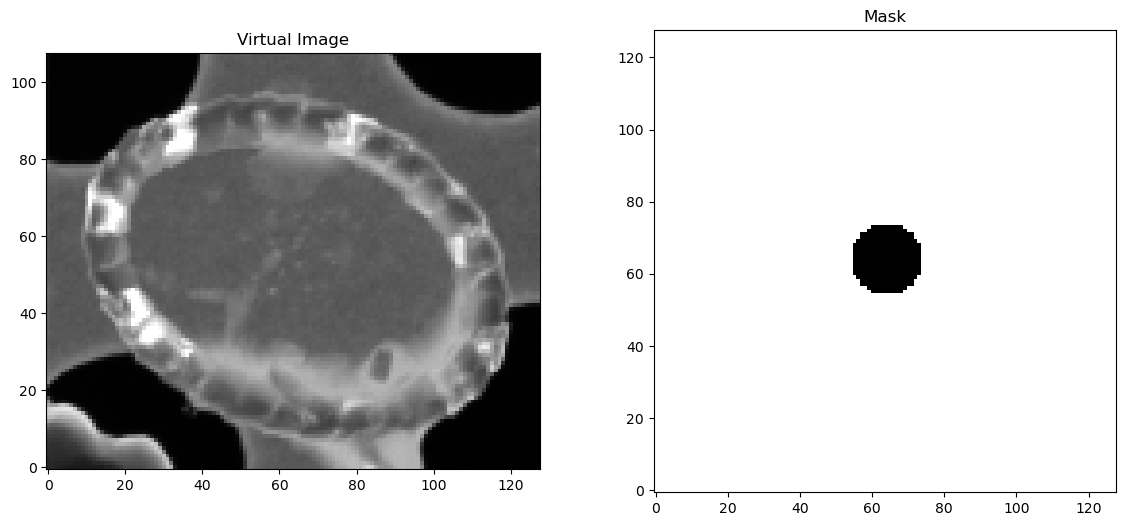

In [7]:
# plot the image
#dispimage=np.log(vimage)
dispimage=adf
plt.figure()
#subplot(r,c) provide the no. of rows and columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
# use the created array to output your multiple images. In this case I have stacked 4 images vertically
ax1.imshow(bytscl(dispimage,vmin=np.mean(dispimage)-3*np.std(dispimage),vmax=np.mean(dispimage)+3*np.std(dispimage)),cmap='gray',origin="lower") 
ax1.set_title('Virtual Image')
ax2.imshow(mask,cmap='gray',origin="lower")
ax2.set_title('Mask')
plt.show()

frame coordinates: 87 47
frame dimensions:  (128, 128)


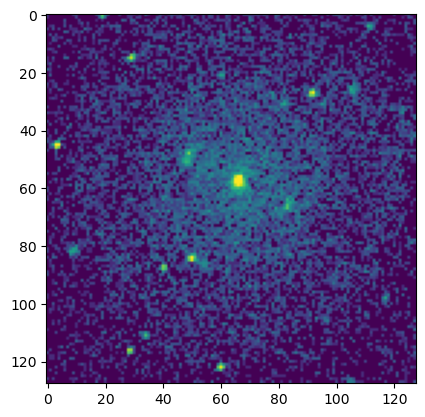

In [8]:
# Display a single frame at row 174, column 94
frame=myset.ShowFrame(i=174//sbin, j=94//sbin,Log=True, sd=6)

### Create a centre-of-mass (COM) map 

In [9]:
centre, comdata=myset.Com(mask=None, optimize=True)

(13824,)
(13824,)


In [10]:
# The comdata is a complex array with the horizontal displacement in the real part
comx=np.real(comdata)
comy=np.imag(comdata)

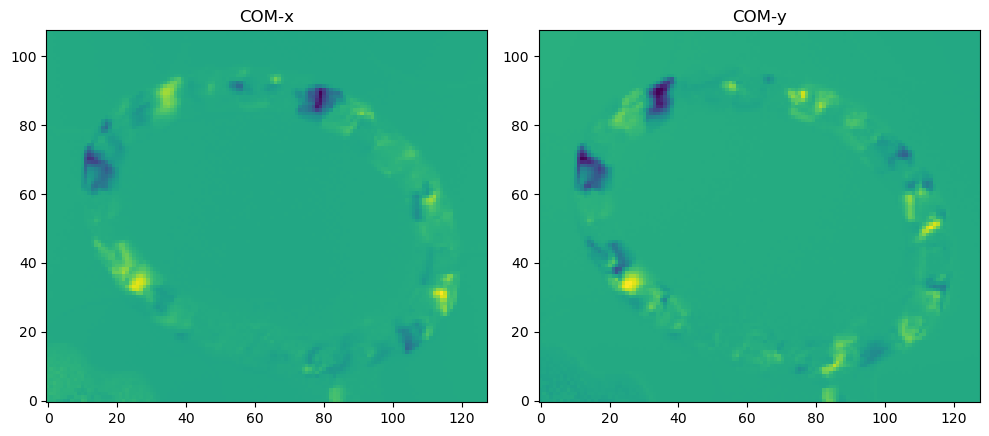

In [11]:
# Create a figure with the the x and y components of the COM
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Display first image
axes[0].imshow(comx, origin='lower')
axes[0].set_title("COM-x")

# Display second image
axes[1].imshow(comy,origin='lower')
axes[1].set_title("COM-y")

plt.tight_layout()
plt.show()


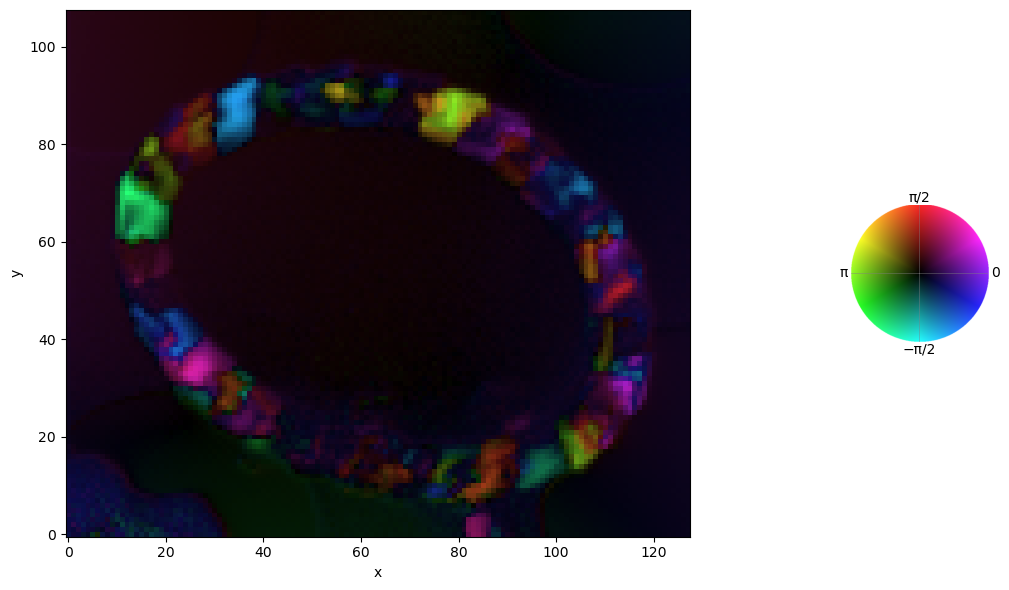

In [12]:
# Use the internal complex data plotting function to map the COM data to a HSV color-coded image 
vdata=np.sqrt(np.abs(comdata))
im=myset.Complex2HSVPlotLgnd(comdata, vdata, clip=(None, 0.5*np.max(vdata)),larmor=90, multiplicity=1,saturation=0.85)

### Let's do the orientation analysis a bit better: Use vectorization to analyze specific lattice reflections 
- Fit Bragg peaks
- Inspect the lattice spacings
- Filter the peaklist for a small range of lattice spacings (corresponding to ideally a single hkl)
- Use the filtered list to create an orientation map, weighted by the intensity of the reflection

In [13]:
# retrieve default peak detection parameters for the Dectris ELA detector 
pars=myset.PreparePeakDetectionPars(shortcut='ELA')
# report parameters
for key,value in pars.items():
    print(key,": ", value)

feature_size :  7
feature_minmass :  2.0
feature_separation :  8
feature_percentile :  65.0
feature_threshold :  1.0
noise_size :  1.0
smooth_size :  None
frame_cmin :  1.0
frame_cmax :  10.0
frame_cutoff :  0.0
conv2D :  True


In [14]:
# adapt parameters, setting conv2D to False speeds up processing
pars["feature_minmass"]=50
pars["feature_threshold"]=2*sbin**2
pars["conv2D"]=False
pars["frame_cmax"]=10.

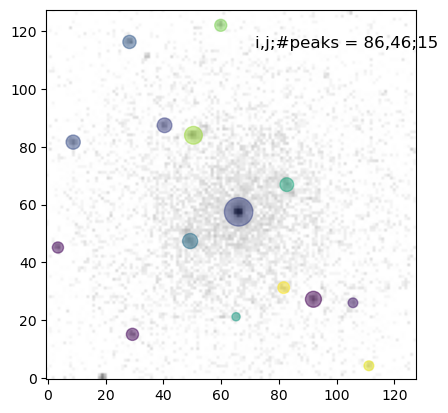

In [15]:
# define region of interest - columns=horizontal axis, rows=vertical axis
rows=np.arange(170//sbin,175//sbin)
cols=np.arange(90//sbin,95//sbin)
# Linearize frame indices
indcs=myset.LinearIndexArray(rows,cols,is_roi=True)
# detect peaks in region of interest
framepeaklist=myset.PeakDetection(indcs,params=pars,animate=True)

In [16]:
# run peak search on all frames
# this may take a little while
rows=np.arange(0,myset.dim[0])
cols=np.arange(0,myset.dim[1])
indcs=myset.LinearIndexArray(rows,cols,is_roi=True)
framepeaklist=myset.PeakDetection(indcs,params=pars,animate=False)

Processing Frames : 100%|██████████████████████████████████████████████████████████| 13824/13824 [00:33<00:00, 411.21it/s]


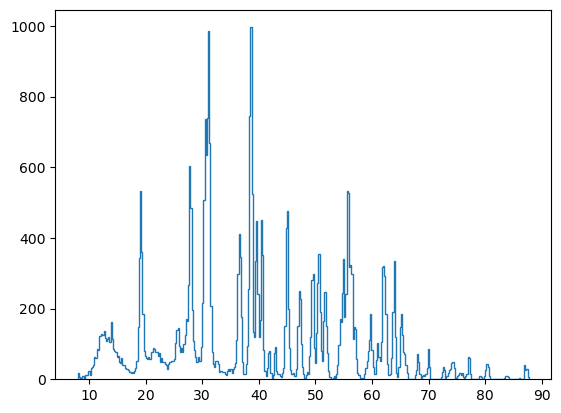

In [17]:
# Use the peaklist to create a histogram of the spacings that occur, i.e. a pseudo powder plot
(counts,bins)=myset.PeakDistanceHistogram(framepeaklist, refine=True, massthresh=20,qrange=[0,120])

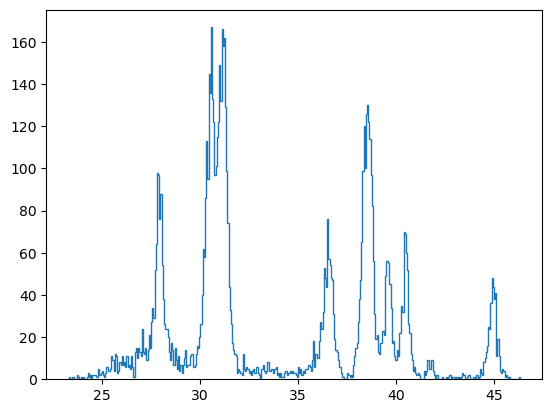

In [18]:
# Use the peaklist to create a histogram of the spacings that occur, i.e. a pseudo powder plot
(counts,bins)=myset.PeakDistanceHistogram(framepeaklist, refine=True, massthresh=20,qrange=[30,40])

In [19]:
# create an orientation map for a specific range of momentum
omap, magmap = myset.OrientationMap(framepeaklist, qrange=[43,46],massthresh=10,refine=True)

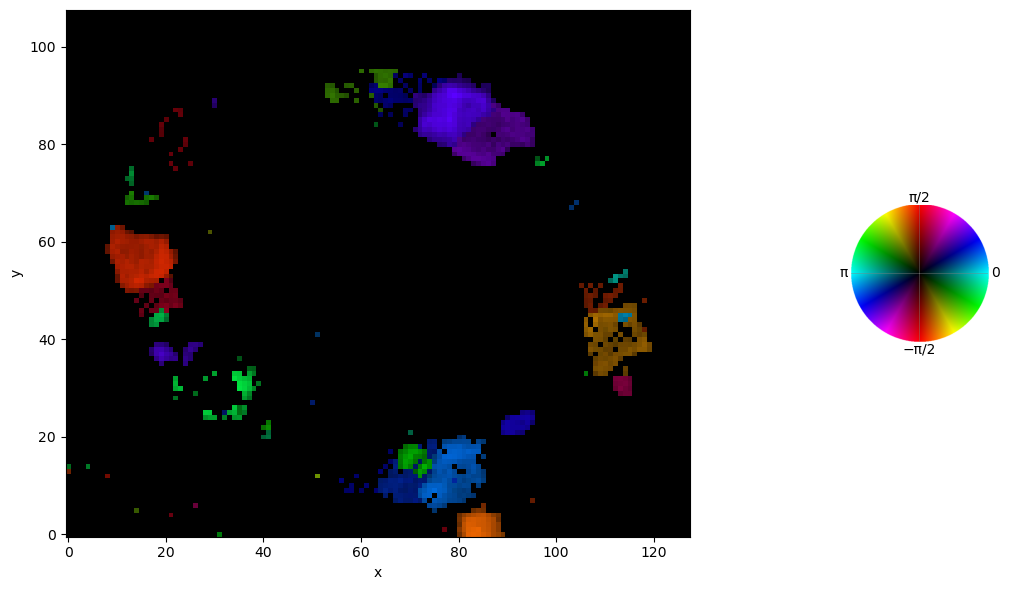

In [20]:
# Plot the orientation data in a hue, saturation, value color encoding
# hue = complex arg
# saturation = constant
# value = magnitude of the reflection, also the square-root or logarithm of it
vdata=np.sqrt(np.abs(magmap))
#v=np.abs(magmap)
im=myset.Complex2HSVPlotLgnd(omap, vdata, clip=(None, 1.*np.max(vdata)), larmor=90., multiplicity=2,saturation=1.)